# EPL Points Prediction

In this notebook, we will:
- Clean the dataset (drop unnecessary columns, nulls, duplicates).
- Perform Exploratory Data Analysis (EDA).
- Encode categorical features.
- Check feature correlations.
- Build regression models to predict **points**.
- Evaluate models using MAE, MSE, RMSE, and R².

## Step 1: Import Libraries
We will import pandas, numpy, matplotlib, seaborn for EDA, and scikit-learn for building & evaluating regression models.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style="whitegrid")

## Step 2: Load the Dataset
Let's load the dataset and inspect the first few rows and columns.

In [3]:
df = pd.read_csv("points.csv")

print("Initial shape:", df.shape)
print("Initial columns:", list(df.columns))
df.head()

Initial shape: (646, 12)
Initial columns: ['season_end_year', 'team', 'position', 'played', 'won', 'drawn', 'lost', 'gf', 'ga', 'gd', 'points', 'notes']


,season_end_year,team,position,played,won,drawn,lost,gf,ga,gd,points,notes
0,1993,Manchester Utd,1,42,24,12,6,67,31,36,84,→ Champions League via league finish
1,1993,Aston Villa,2,42,21,11,10,57,40,17,74,→ UEFA Cup via league finish
2,1993,Norwich City,3,42,21,9,12,61,65,-4,72,→ UEFA Cup via league finish 1
3,1993,Blackburn,4,42,20,11,11,68,46,22,71,NaN
4,1993,QPR,5,42,17,12,13,63,55,8,63,NaN


## Step 3: Drop Unnecessary Columns
We only need the following columns:
- `team`
- `position`
- `gf` (goals for)
- `ga` (goals against)
- `gd` (goal difference)
- `points` (target variable)

Let's drop the rest.

In [4]:
print("Columns before drop:", list(df.columns))

df = df.drop(['season_end_year', 'played', 'won', 'drawn', 'lost', 'notes'], axis=1)

print("Columns after drop:", list(df.columns))
df.head()

Columns before drop: ['season_end_year', 'team', 'position', 'played', 'won', 'drawn', 'lost', 'gf', 'ga', 'gd', 'points', 'notes']
Columns after drop: ['team', 'position', 'gf', 'ga', 'gd', 'points']


,team,position,gf,ga,gd,points
0,Manchester Utd,1,67,31,36,84
1,Aston Villa,2,57,40,17,74
2,Norwich City,3,61,65,-4,72
3,Blackburn,4,68,46,22,71
4,QPR,5,63,55,8,63


## Step 4: Check for Null Values
We check for missing values in each column.  
If there are any, we will drop those rows.

In [5]:
print("Missing values before handling:")
print(df.isnull().sum())

if df.isnull().sum().sum() == 0:
    print("\nNo missing values found")
else:
    df = df.dropna()
    print("\nMissing values handled. After dropping:")
    print(df.isnull().sum())

Missing values before handling:
team        0
position    0
gf          0
ga          0
gd          0
points      0
dtype: int64

No missing values found


## Step 5: Check for Duplicate Rows
Duplicates can bias our model, so we check and remove them if present.

In [6]:
print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplicates after:", df.duplicated().sum())

Duplicates before: 0
Duplicates after: 0


## Step 6: Encode the `team` Column
The `team` column is categorical.  
We will use **One-Hot Encoding** to convert it into numeric columns.

In [7]:
print("Shape before encoding:", df.shape)
df_encoded = pd.get_dummies(df, columns=['team'], drop_first=True)
print("Shape after encoding:", df_encoded.shape)

df_encoded.head()

Shape before encoding: (646, 6)
Shape after encoding: (646, 55)


,position,gf,ga,gd,points,team_Aston Villa,team_Barnsley,team_Birmingham City,team_Blackburn,team_Blackpool,...,team_Sunderland,team_Swansea City,team_Swindon Town,team_Tottenham,team_Watford,team_West Brom,team_West Ham,team_Wigan Athletic,team_Wimbledon,team_Wolves
0,1,67,31,36,84,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,57,40,17,74,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,61,65,-4,72,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,68,46,22,71,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,5,63,55,8,63,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Step 7: Correlation Analysis
We check correlations between numeric features and `points`.
This helps us understand which features are most strongly related to our target.

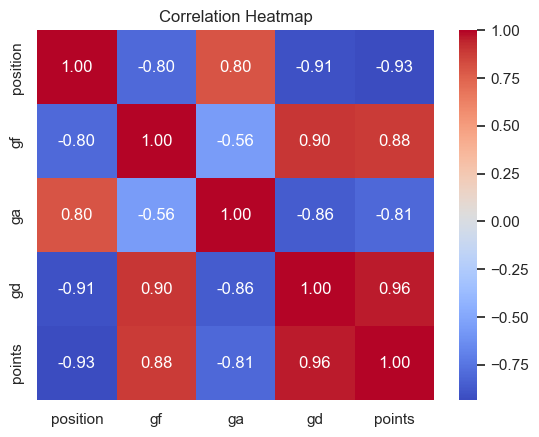

Correlation with points:
points      1.000000
gd          0.958271
gf          0.879260
ga         -0.809380
position   -0.934208
Name: points, dtype: float64


In [8]:
corr = df_encoded[['position','gf','ga','gd','points']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

print("Correlation with points:")
print(corr['points'].sort_values(ascending=False))

## Step 8: Prepare Data for Modeling
We separate features (`X`) and target (`y`).  
Note: we drop `position` to avoid leakage since it's derived from points.

In [9]:
X = df_encoded.drop(columns=['points', 'position'])
y = df_encoded['points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (516, 53) Test shape: (130, 53)


## Step 9: Train Regression Models
We will train:
- Linear Regression (baseline)
- Random Forest Regressor (non-linear, often more accurate)

In [10]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

## Step 10: Evaluate Models
We will use:
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- R² Score

In [11]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

print("Linear Regression:", evaluate(y_test, y_pred_lr))
print("Random Forest:", evaluate(y_test, y_pred_rf))

Linear Regression: {'MAE': 3.9292445670830585, 'RMSE': np.float64(5.12294680289808), 'R2': 0.9000902231692166}
Random Forest: {'MAE': 3.935653846153846, 'RMSE': np.float64(5.0201043802782515), 'R2': 0.9040613084349876}


## Step 11: Sample Predictions
Let's compare actual vs predicted points for a few test cases.

In [12]:
comparison = pd.DataFrame({
    "Actual": y_test[:10].values,
    "Predicted_LR": y_pred_lr[:10],
    "Predicted_RF": y_pred_rf[:10]
})
comparison

,Actual,Predicted_LR,Predicted_RF
0,60,55.149275,54.59
1,71,75.606094,74.62
2,41,44.822281,43.00
3,56,49.285630,49.39
4,61,61.134759,67.67
5,45,41.950241,44.31
6,46,46.558120,47.14
7,45,45.856710,44.56
8,54,48.766758,48.75
9,52,47.697712,48.92


## Step 12: Scatterplots (Actual vs Predicted)

Tables are good, but visualizations really help us understand model performance.  
We’ll plot the actual vs predicted points for both models.  
If the predictions are perfect, all points will lie on the red diagonal line.

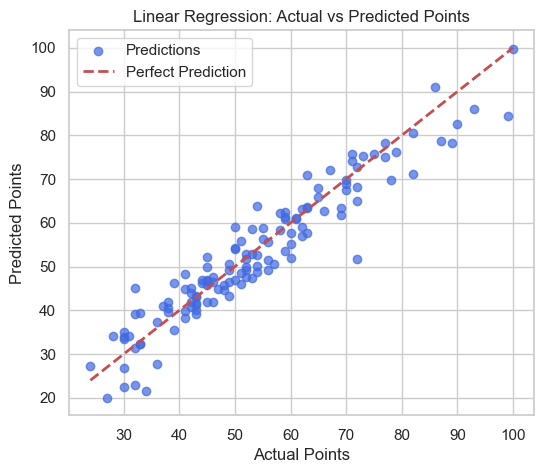

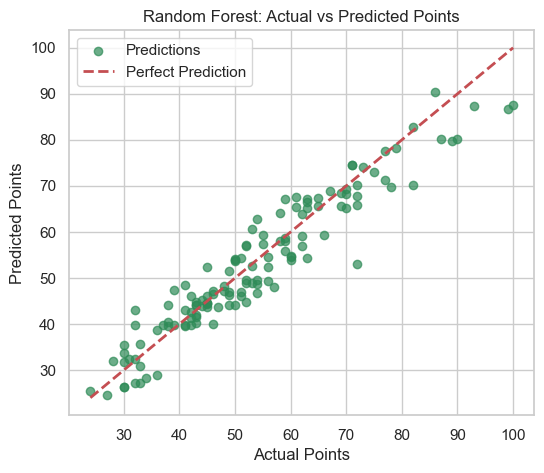

In [13]:
# Scatterplot for Linear Regression
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_lr, alpha=0.7, color="royalblue", label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2, label="Perfect Prediction")
plt.title("Linear Regression: Actual vs Predicted Points")
plt.xlabel("Actual Points")
plt.ylabel("Predicted Points")
plt.legend()
plt.show()

# Scatterplot for Random Forest
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_rf, alpha=0.7, color="seagreen", label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2, label="Perfect Prediction")
plt.title("Random Forest: Actual vs Predicted Points")
plt.xlabel("Actual Points")
plt.ylabel("Predicted Points")
plt.legend()
plt.show()

## Step 13: Hyperparameter Tuning

Now we will apply hyperparameter tuning to improve our regression models.  
We’ll use **GridSearchCV** to find the best set of parameters for both:
- **Linear Regression** (not much to tune, but we can compare fit intercept, normalization, etc.)
- **Random Forest Regressor** (more impactful tuning).

In [15]:
from sklearn.model_selection import GridSearchCV

# Linear Regression Hyperparameters
param_grid_lr = {
    "fit_intercept": [True, False],
    "positive": [True, False]
}

grid_lr = GridSearchCV(
    LinearRegression(),
    param_grid_lr,
    cv=5,
    scoring="r2",
    n_jobs=-1
)
grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
print("Best Linear Regression Params:", grid_lr.best_params_)

# Random Forest Hyperparameters
param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_rf,
    cv=5,
    scoring="r2",
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print("Best Random Forest Params:", grid_rf.best_params_)

Best Linear Regression Params: {'fit_intercept': True, 'positive': True}
Best Random Forest Params: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}


## Step 14: Evaluate Tuned Models

Now we’ll evaluate the tuned models using the same metrics:  
**MAE, RMSE, and R²**.

In [16]:
# Predictions with best models
y_pred_lr_best = best_lr.predict(X_test)
y_pred_rf_best = best_rf.predict(X_test)

print("Tuned Linear Regression:", evaluate(y_test, y_pred_lr_best))
print("Tuned Random Forest:", evaluate(y_test, y_pred_rf_best))

Tuned Linear Regression: {'MAE': 3.9057339296050735, 'RMSE': np.float64(5.033599093080231), 'R2': 0.9035448230762675}
Tuned Random Forest: {'MAE': 3.8457105252367367, 'RMSE': np.float64(4.910906546813083), 'R2': 0.9081896514831295}


## Step 15: Compare Performances

We will now compare the baseline models vs the tuned models to see if tuning improved the results.

In [17]:
comparison_results = pd.DataFrame({
    "Model": ["Linear Regression (Baseline)", "Linear Regression (Tuned)",
              "Random Forest (Baseline)", "Random Forest (Tuned)"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_lr_best),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_rf_best)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_lr_best)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
    ],
    "R2": [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_lr_best),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_rf_best)
    ]
})

comparison_results

,Model,MAE,RMSE,R2
0,Linear Regression (Baseline),3.929245,5.122947,0.900090
1,Linear Regression (Tuned),3.905734,5.033599,0.903545
2,Random Forest (Baseline),3.935654,5.020104,0.904061
3,Random Forest (Tuned),3.845711,4.910907,0.908190


## Step 16: Visualization of Tuned Models

Let’s again plot **Actual vs Predicted Points** for the tuned models.

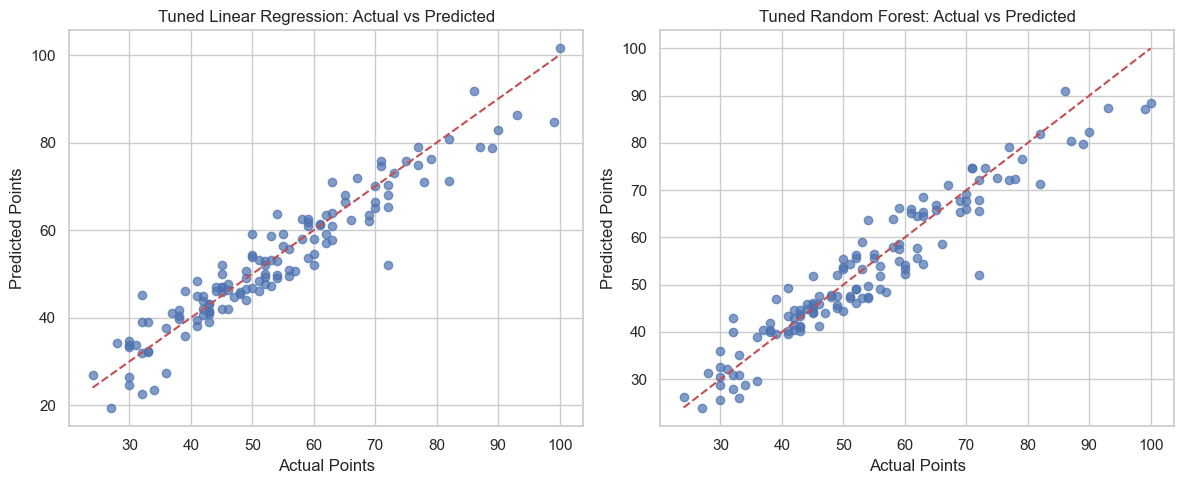

In [18]:
plt.figure(figsize=(12,5))

# Linear Regression
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_lr_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Points")
plt.ylabel("Predicted Points")
plt.title("Tuned Linear Regression: Actual vs Predicted")

# Random Forest
plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_rf_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Points")
plt.ylabel("Predicted Points")
plt.title("Tuned Random Forest: Actual vs Predicted")

plt.tight_layout()
plt.show()